In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

plt.rcParams.update({
    "font.size": 14
}) 

In [159]:
def calculate_cv(theta_2, theta_3):
    sigma_h_sq = theta_3 ** 2 / (1 - theta_2 ** 2)
    return np.exp(sigma_h_sq) - 1

def plot_cv_theta_two(df_qml, df_smm, title, x_bounds=None, y_bounds=None):
    _, ax = plt.subplots(figsize=(7, 7))
    sns.scatterplot(data=df_qml, x="cv", y="estimates_2", ax=ax, label="QML");
    sns.scatterplot(data=df_smm, x="cv", y="estimates_2", ax=ax, label="SMM");
    ax.set_xlabel("CV")
    ax.set_ylabel("theta_2")
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)

def plot_qml_vs_smm_estimates(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 7))

    for i in range(3):
        qml_col = f"estimates_{i+1}_qml"
        smm_col = f"estimates_{i+1}_smm"
        min_value = min(df[qml_col].min(), df[smm_col].min())
        max_vallue = max(df[qml_col].max(), df[smm_col].max())
        y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
        sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax[i], label="y=x", color="red", linestyle="--")
        sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax[i]);
    fig.suptitle(title)
    plt.tight_layout()


def plot_qml_vs_smm_cv(df, title,  x_bounds=None, y_bounds=None):
    fig, ax = plt.subplots(figsize=(7, 7))

    qml_col = "cv_qml"
    smm_col = "cv_smm"
    min_value = min(df[qml_col].min(), df[smm_col].min())
    max_vallue = max(df[qml_col].max(), df[smm_col].max())
    y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
    sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax, label="y=x", color="red", linestyle="--")
    sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax);
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)
    

In [158]:
def get_winner(theta_2, cv, size):
    is_short = size < 1000
    is_long = 1 - is_short

    is_cv_big = cv > 10
    is_cv_med = (1 - is_cv_big) * (cv > 1)
    is_cv_small = 1 - is_cv_big - is_cv_med

    is_theta_small = theta_2 < 0.9
    is_theta_med = (1 - is_theta_small) * (theta_2 < 0.95)
    is_theta_big = 1 - is_theta_small - is_theta_med

    wins_qml = np.zeros_like(size)
    wins_qml += is_long * is_cv_big
    wins_qml += is_long * is_theta_big * is_cv_med
    wins_qml += (size >= 2000) * is_theta_big * is_cv_small
    wins_qml += is_short * (size > 500) * is_theta_small * is_cv_big
    wins_qml = wins_qml > 0

    wins_smm = np.zeros_like(size)
    wins_smm += (size < 2000) * is_cv_small
    wins_smm += (size > 2000) * (size < 4000) * is_cv_small * is_theta_med
    wins_smm += is_cv_med * (1 - is_theta_big)
    wins_smm += is_short * is_theta_big * is_cv_med
    wins_smm = wins_smm > 0

    is_draw = 1 - wins_qml - wins_smm > 0

    smm_literal = pd.Series(["SMM" if flag else "" for flag in wins_smm])
    qml_literal = pd.Series(["QML" if flag else "" for flag in wins_qml])
    draw_literal = pd.Series(["?" if flag else "" for flag in is_draw])
    return smm_literal + qml_literal + draw_literal


def determine_winner(winner_qml, winner_smm):
    is_draw_qml = winner_qml == "?"
    is_draw_smm = winner_smm == "?"

    is_winner =  (winner_smm == winner_qml) * (1 - is_draw_qml) * (1 - is_draw_smm)
    return np.where(is_winner, winner_qml, pd.Series(["?" for _ in range(len(winner_qml))]))



In [76]:
qml_with_outliers = pd.read_csv("qml_estimates_with_outliers.csv")
smm_with_outliers = pd.read_csv("smm_estimates_with_outliers.csv")

qml_without_outliers = pd.read_csv("qml_estimates_without_outliers.csv")
smm_without_outliers = pd.read_csv("smm_estimates_without_outliers.csv")
dfs = [qml_with_outliers, qml_without_outliers, smm_with_outliers, smm_without_outliers]

for df in dfs:
    df["cv"] = calculate_cv(df.estimates_2, df.estimates_3)


with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instea

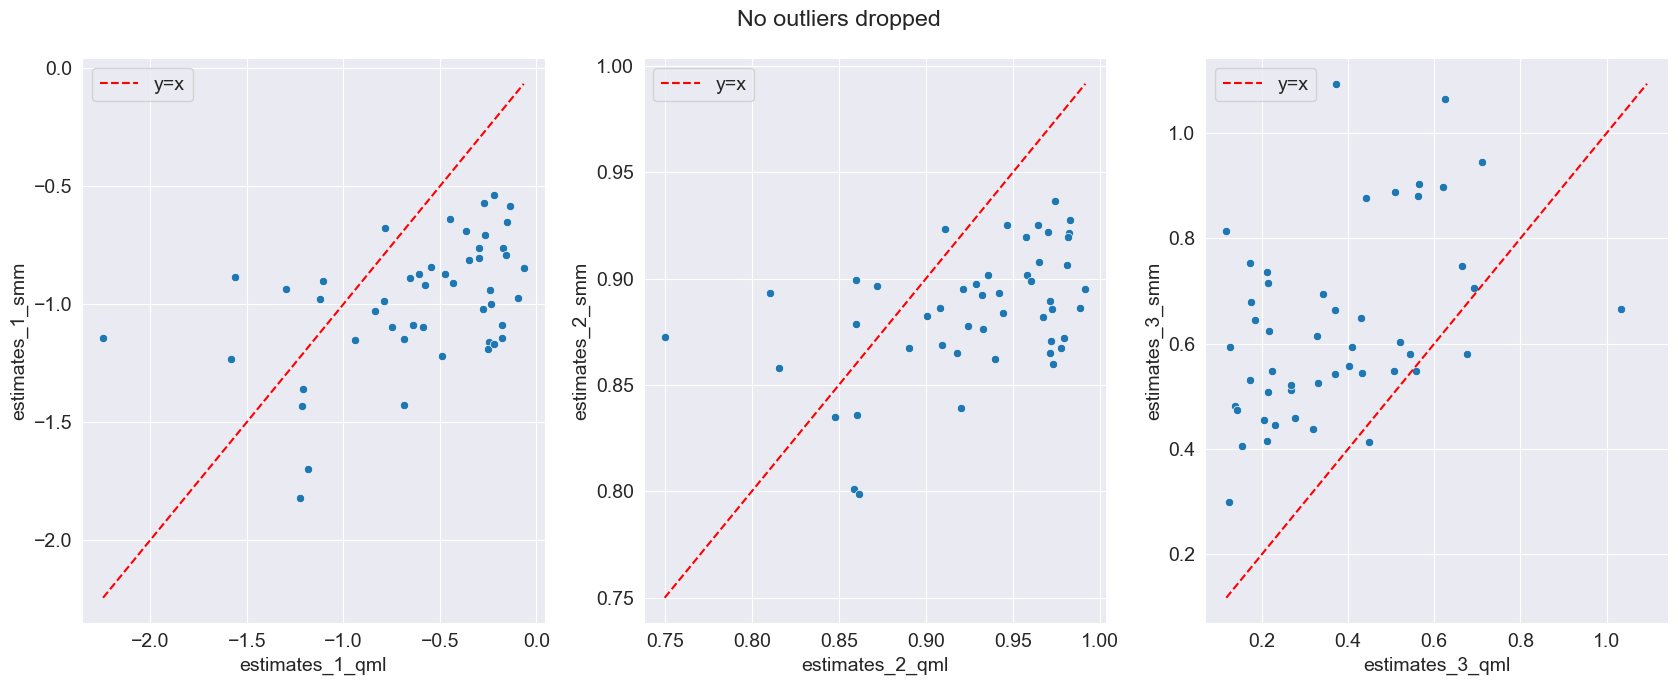

In [78]:
plot_qml_vs_smm_estimates(with_outliers, "No outliers dropped")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instea

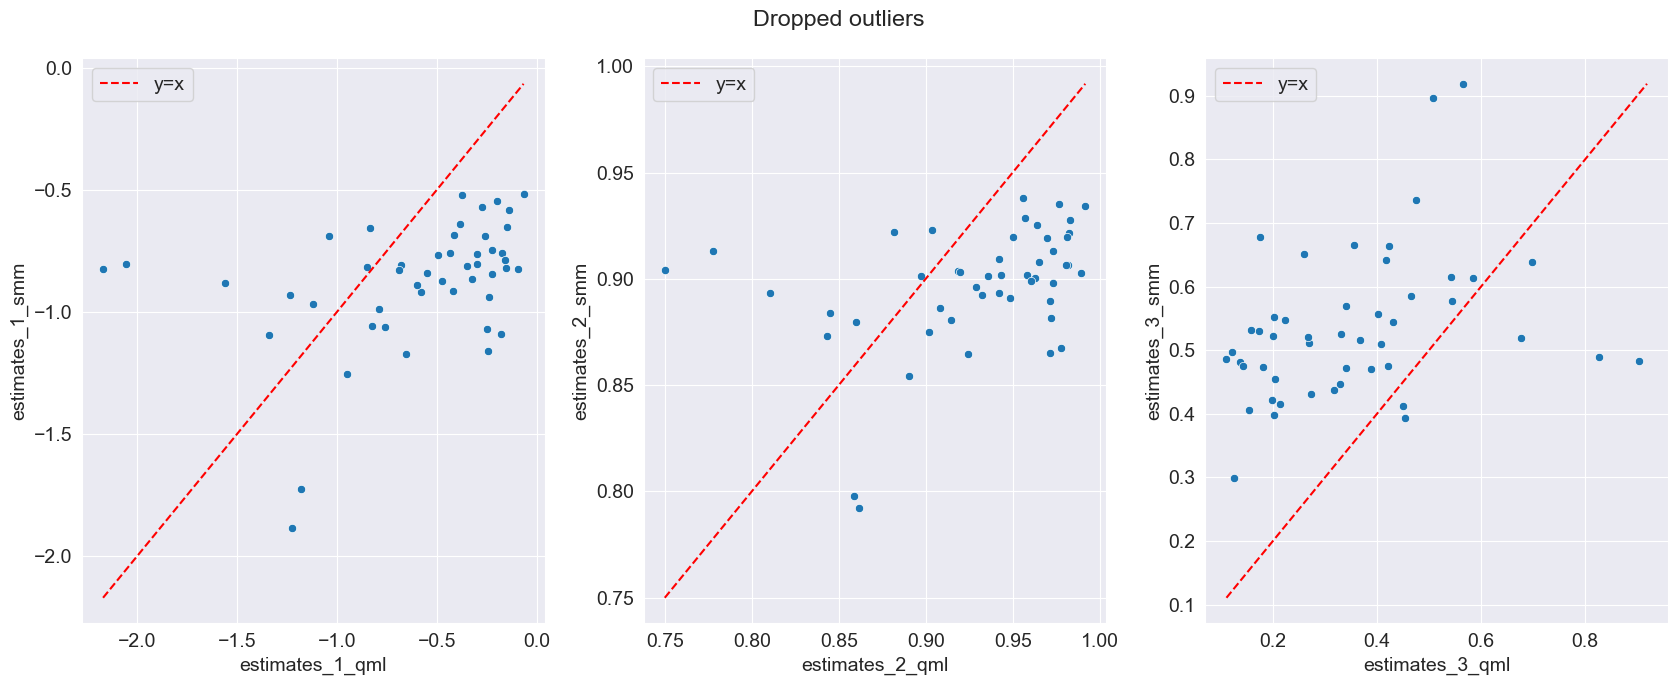

In [79]:
plot_qml_vs_smm_estimates(without_outliers, "Dropped outliers")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



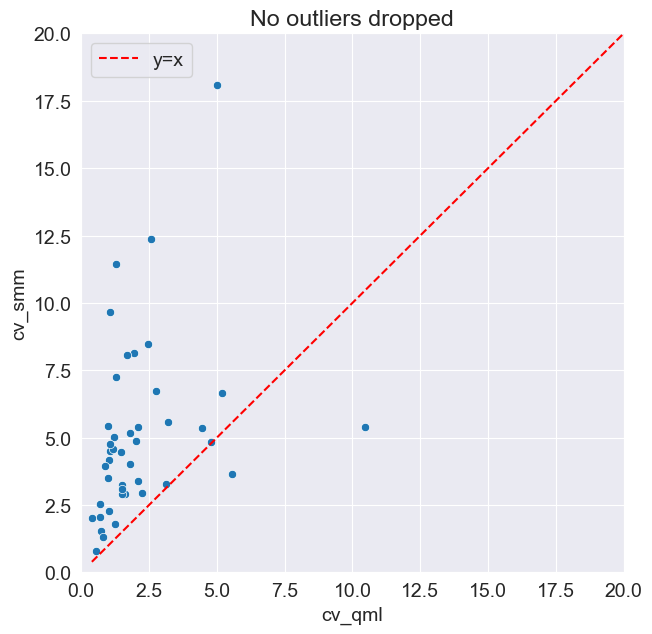

In [80]:
plot_qml_vs_smm_cv(with_outliers, "No outliers dropped", x_bounds=(0, 20), y_bounds=(0, 20))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



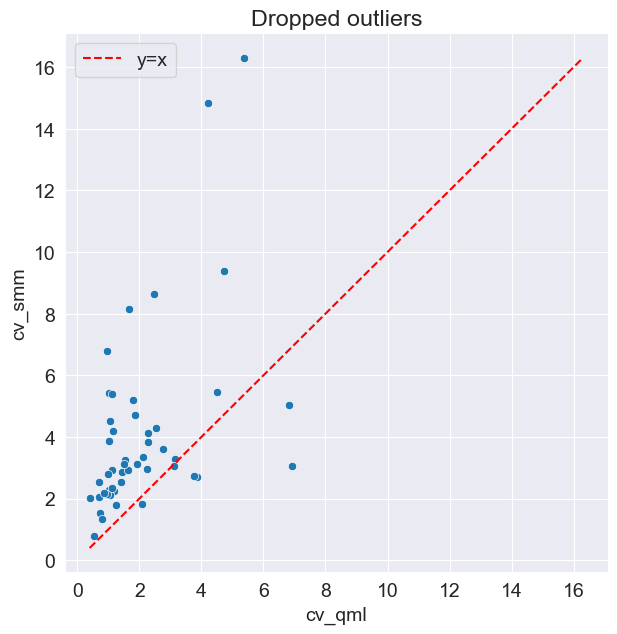

In [81]:
plot_qml_vs_smm_cv(without_outliers, "Dropped outliers")

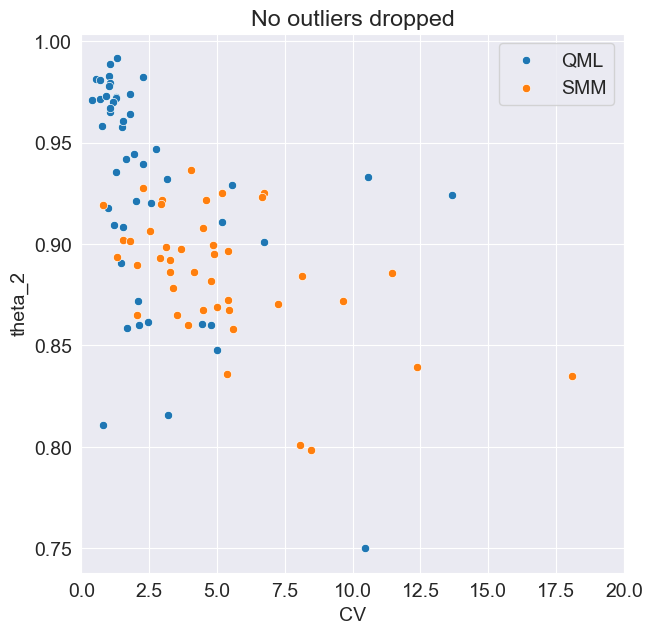

In [82]:
plot_cv_theta_two(qml_with_outliers, smm_with_outliers, "No outliers dropped", x_bounds=(0, 20))

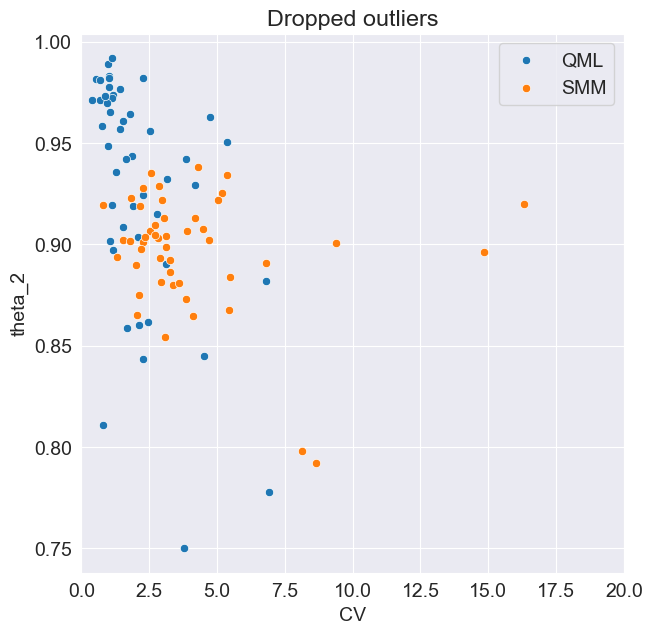

In [83]:
plot_cv_theta_two(qml_without_outliers, smm_without_outliers, "Dropped outliers", x_bounds=(0, 20))

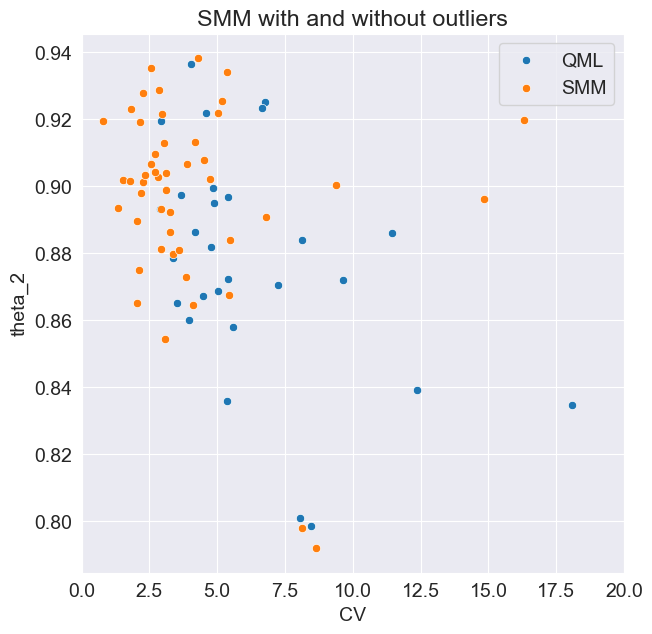

In [84]:
plot_cv_theta_two(smm_with_outliers, smm_without_outliers, "SMM with and without outliers", x_bounds=(0, 20))

In [86]:
smm_with_outliers['name'] = 'smm_with_outliers'
smm_without_outliers['name'] = 'smm_without_outliers'
qml_without_outliers['name'] = 'qml_without_outliers'
qml_with_outliers['name'] = 'qml_with_outliers'


data_length = pd.read_csv('data/merged_data.csv')
data_length =  data_length.groupby(by='ticker').count()['date']

for df in dfs:
    df.set_index('ticker', inplace = True)
    df['size'] = data_length


for df in dfs:
    df["winner"] = get_winner(df["estimates_2"], df["cv"], df["size"]).to_list()


with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))


In [155]:
pd.Series(determine_winner(with_outliers.winner_qml, with_outliers.winner_smm)).value_counts(normalize=True)

?      0.541667
SMM    0.437500
QML    0.020833
Name: proportion, dtype: float64

In [154]:
pd.Series(determine_winner(without_outliers.winner_qml, without_outliers.winner_smm)).value_counts(normalize=True)


SMM    0.5625
?      0.4375
Name: proportion, dtype: float64

In [157]:
without_outliers


,estimates_1_qml,estimates_2_qml,estimates_3_qml,cv_qml,size_qml,name_qml,winner_qml,estimates_1_smm,estimates_2_smm,estimates_3_smm,cv_smm,size_smm,name_smm,winner_smm
ticker,,,,,,,,,,,,,,
AFKS,-0.848200,0.897031,0.388591,1.166354,2323,qml_without_outliers,SMM,-0.813689,0.901284,0.470587,2.254055,2323,smm_without_outliers,SMM
AFLT,-0.677685,0.918708,0.407844,1.904984,2323,qml_without_outliers,SMM,-0.807593,0.903855,0.509211,3.122934,2323,smm_without_outliers,SMM
AGRO,-0.577343,0.932188,0.431502,3.141461,2298,qml_without_outliers,SMM,-0.916565,0.892177,0.544191,3.269719,2298,smm_without_outliers,SMM
ALRS,-0.346496,0.958155,0.213216,0.741615,2323,qml_without_outliers,QML,-0.812531,0.901828,0.416201,1.528908,2323,smm_without_outliers,SMM
BSPB,-0.655392,0.924218,0.416618,2.288093,2321,qml_without_outliers,SMM,-1.172861,0.864563,0.642326,4.123254,2321,smm_without_outliers,SMM
CBOM,-0.173194,0.982202,0.204142,2.258565,2203,qml_without_outliers,QML,-0.759176,0.921572,0.455197,2.954672,2203,smm_without_outliers,SMM
CHMF,-0.239182,0.971257,0.137365,0.395178,2323,qml_without_outliers,QML,-0.939088,0.889566,0.480987,2.030319,2323,smm_without_outliers,SMM
ENPG,-1.118254,0.859984,0.543504,2.108926,1031,qml_without_outliers,SMM,-0.965947,0.879787,0.576755,3.358148,1031,smm_without_outliers,SMM
FEES,-0.370991,0.955771,0.330027,2.522398,2309,qml_without_outliers,QML,-0.522026,0.938173,0.446529,4.279961,2309,smm_without_outliers,SMM


In [29]:
full_df = pd.concat([smm_with_outliers, qml_with_outliers])

In [30]:
import plotly_express as px


In [31]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

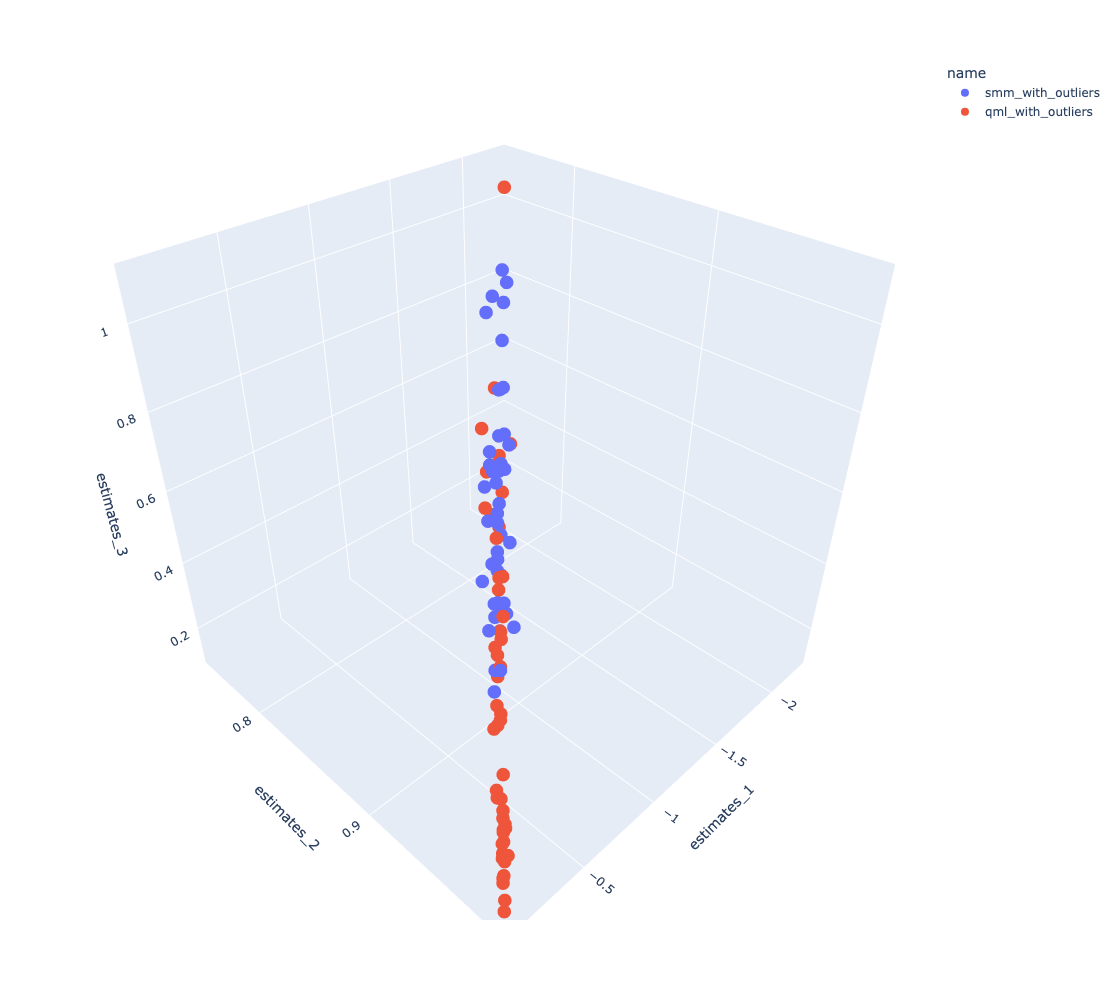

In [32]:
fig = px.scatter_3d(full_df, x="estimates_1", y="estimates_2", z="estimates_3", 
              color="name")
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000
)
fig.show()



In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.show()

In [22]:
jupyter-notebook

  Obtaining dependency information for jupyter from https://files.pythonhosted.org/packages/83/df/0f5dd132200728a86190397e1ea87cd76244e42d39ec5e88efd25b2abd7e/jupyter-1.0.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for notebook from https://files.pythonhosted.org/packages/08/e6/e032f6a4d3da85c4bd38b6ff96de51347bfb0d932ea1d2ccfd89c6374c8a/notebook-7.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for qtconsole from https://files.pythonhosted.org/packages/f2/3f/de5e5eb44900c1ed1c1567bc505e3b6e6f4c01cf29e558bf2f8cee29af5b/qtconsole-5.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for jupyter-console from https://files.pythonhosted.org/packages/ca/77/71d78d58f15c22db16328a476426f7ac4a60d3a5a7ba3b9627ee2f7903d4/jupyter_console-6.6.3-py3-none-any.whl.metadata
  Obtaining dependency information for nbconvert from https://files.pythonhosted.org/packages/b8/bb/bb5b6a515d1584aa2fd89965b11db6632e4bdc69495a52374bcc36e56cfa/nbconvert-7.16.4-